<a href="https://colab.research.google.com/github/deding2000/COMP5329_Ass2/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Not needed before we upload files to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from google.colab import files
uploaded = files.upload() # select all python files from the github page and kaggle.json

Saving Dataload.py to Dataload.py
Saving kaggle.json to kaggle.json
Saving metrics.py to metrics.py
Saving pos_weight.py to pos_weight.py
Saving samples_weight.pt to samples_weight.pt
Saving samples_weight_subset.pt to samples_weight_subset.pt
Saving subset_train_indices.npy to subset_train_indices.npy
Saving utils.py to utils.py
Saving validation_indices.npy to validation_indices.npy


In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'multi-label-classification-competition-2025'
! mkdir Dataset
! unzip multi-label-classification-competition-2025.zip -d Dataset &> /dev/null

 97% 388M/399M [00:00<00:00, 1.35GB/s]
100% 399M/399M [00:00<00:00, 1.35GB/s]


In [4]:
# Model arcitechture
import torch.nn.functional as F
from torch import nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()  # Compulsory operation.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=7, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 5, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32,3, stride=1,padding=1)
        self.pool = nn.MaxPool2d(3,stride=2)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm1d(1000)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.25)
        self.dropout3 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(6272, 1000)
        self.fc2 = nn.Linear(1000, 19)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout3(x)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout3(x)
        logits = self.fc2(x)
        return logits

We are using GPU.
tensor([22794.,  1162.,  4364.,  1272.,  1130.,  1394.,  1221.,  2210.,  1042.,
         1471.,   604.,     0.,   605.,   251.,  1934.,  1099.,  1430.,  1525.,
         1020.], dtype=torch.float64)
Using loss weights: tensor([0.0110, 0.2160, 0.0575, 0.1973, 0.2221, 0.1801, 0.2056, 0.1136, 0.2409,
        0.1706, 0.4156, 0.0054, 0.4149, 1.0000, 0.1298, 0.2284, 0.1755, 0.1646,
        0.2461], dtype=torch.float64)
Model initialized.


  0%|          | 0/30 [00:00<?, ?it/s]


Train Epoch: 0 [0/23996 (0%)]	Loss: 0.160607


  3%|▎         | 1/30 [01:41<49:10, 101.73s/it]


Train Epoch: 1 [0/23996 (0%)]	Loss: 0.042815


  7%|▋         | 2/30 [03:15<45:13, 96.92s/it] 


Train Epoch: 2 [0/23996 (0%)]	Loss: 0.038692


 10%|█         | 3/30 [04:50<43:11, 95.98s/it]


Train Epoch: 3 [0/23996 (0%)]	Loss: 0.037277


 13%|█▎        | 4/30 [06:26<41:36, 96.01s/it]


Train Epoch: 4 [0/23996 (0%)]	Loss: 0.039240


 17%|█▋        | 5/30 [08:01<39:55, 95.82s/it]


Train Epoch: 5 [0/23996 (0%)]	Loss: 0.039688


 20%|██        | 6/30 [09:36<38:11, 95.50s/it]


Train Epoch: 6 [0/23996 (0%)]	Loss: 0.033186


 23%|██▎       | 7/30 [11:12<36:40, 95.69s/it]


Train Epoch: 7 [0/23996 (0%)]	Loss: 0.033694


 27%|██▋       | 8/30 [12:45<34:42, 94.66s/it]


Train Epoch: 8 [0/23996 (0%)]	Loss: 0.036679


 30%|███       | 9/30 [14:18<32:57, 94.17s/it]


Train Epoch: 9 [0/23996 (0%)]	Loss: 0.039103


 33%|███▎      | 10/30 [15:50<31:09, 93.46s/it]


Train Epoch: 10 [0/23996 (0%)]	Loss: 0.035487


 37%|███▋      | 11/30 [17:23<29:34, 93.41s/it]


Train Epoch: 11 [0/23996 (0%)]	Loss: 0.034683


 40%|████      | 12/30 [18:54<27:51, 92.87s/it]


Train Epoch: 12 [0/23996 (0%)]	Loss: 0.033722


 43%|████▎     | 13/30 [20:26<26:13, 92.54s/it]


Train Epoch: 13 [0/23996 (0%)]	Loss: 0.037336


 47%|████▋     | 14/30 [21:59<24:41, 92.60s/it]


Train Epoch: 14 [0/23996 (0%)]	Loss: 0.036873


 50%|█████     | 15/30 [23:32<23:11, 92.79s/it]


Train Epoch: 15 [0/23996 (0%)]	Loss: 0.033724


 53%|█████▎    | 16/30 [25:04<21:35, 92.55s/it]


Train Epoch: 16 [0/23996 (0%)]	Loss: 0.032877


 57%|█████▋    | 17/30 [26:36<19:58, 92.19s/it]


Train Epoch: 17 [0/23996 (0%)]	Loss: 0.033950


 60%|██████    | 18/30 [28:08<18:25, 92.14s/it]


Train Epoch: 18 [0/23996 (0%)]	Loss: 0.031225


 63%|██████▎   | 19/30 [29:40<16:53, 92.14s/it]


Train Epoch: 19 [0/23996 (0%)]	Loss: 0.032740


 67%|██████▋   | 20/30 [31:11<15:19, 91.98s/it]


Train Epoch: 20 [0/23996 (0%)]	Loss: 0.034560


 70%|███████   | 21/30 [32:42<13:45, 91.68s/it]


Train Epoch: 21 [0/23996 (0%)]	Loss: 0.035407


 73%|███████▎  | 22/30 [34:14<12:13, 91.72s/it]


Train Epoch: 22 [0/23996 (0%)]	Loss: 0.034515


 77%|███████▋  | 23/30 [35:46<10:43, 91.86s/it]


Train Epoch: 23 [0/23996 (0%)]	Loss: 0.039629


 80%|████████  | 24/30 [37:19<09:11, 91.97s/it]


Train Epoch: 24 [0/23996 (0%)]	Loss: 0.034012


 83%|████████▎ | 25/30 [38:50<07:39, 91.89s/it]


Train Epoch: 25 [0/23996 (0%)]	Loss: 0.033976


 87%|████████▋ | 26/30 [40:22<06:07, 91.77s/it]


Train Epoch: 26 [0/23996 (0%)]	Loss: 0.035109


 90%|█████████ | 27/30 [41:54<04:35, 91.90s/it]


Train Epoch: 27 [0/23996 (0%)]	Loss: 0.031168


 93%|█████████▎| 28/30 [43:27<03:04, 92.26s/it]


Train Epoch: 28 [0/23996 (0%)]	Loss: 0.029488


 97%|█████████▋| 29/30 [44:59<01:32, 92.17s/it]


Train Epoch: 29 [0/23996 (0%)]	Loss: 0.035951


100%|██████████| 30/30 [46:31<00:00, 93.06s/it]


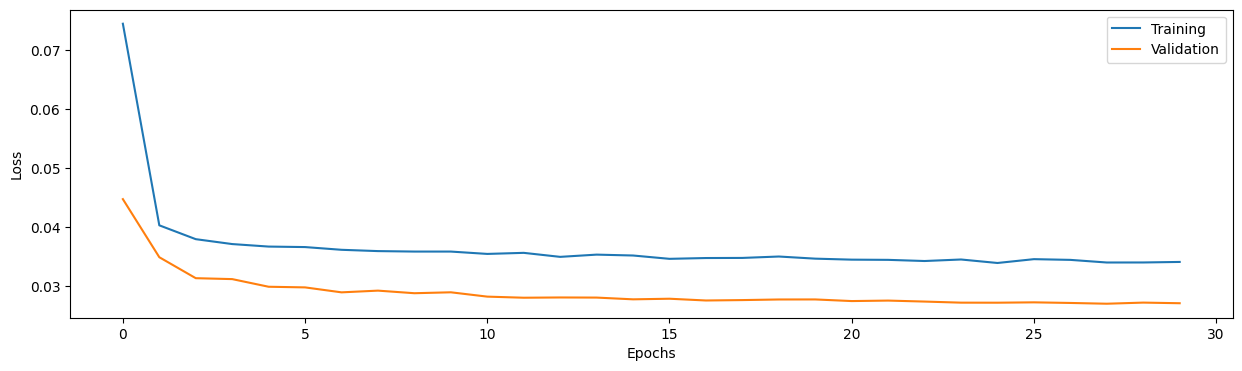

UnboundLocalError: cannot access local variable 'precision' where it is not associated with a value

In [5]:
import re
import pandas as pd
from io import StringIO
import os
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, random_split, WeightedRandomSampler

from Dataload import pil_process_image_color, encode, CustomImageDataset
from utils import train_network, pos_weight, test
from metrics import compute_metrics
from sklearn.metrics import confusion_matrix
import torch
import numpy as np
from tqdm import tqdm

# Hyperparameters
batch_size = 256
lr = 0.0001
weight_decay = 0
thresholds = [0.5]*19
thresholds[11] = 1.1 # never predict class 12
INPUT_HEIGHT = 256
INPUT_WIDTH = 256

# Set device to GPU if this is available
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')

# Loading filenames and labels
# Assumes data is in folder "Dataset"
DATASET_PATH = "/content/Dataset/COMP5329S1A2Dataset/"
FILENAME_TRAIN = 'train.csv'
FILENAME_TEST = 'test.csv'

with open(DATASET_PATH + FILENAME_TRAIN) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
with open(DATASET_PATH + FILENAME_TEST) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
df_train.to_csv("train_labels_captions.csv")
df_test.to_csv("test_labels_captions.csv")

# To get overview
#print(df_test.describe)

# Defining transforms

resize = transforms.Resize(size=(INPUT_HEIGHT,
        INPUT_WIDTH)) # Trying to resize to (INPUT_HEIGHT,INPUT_WIDTH)

trainTransforms_basic = transforms.Compose(
    [resize,transforms.ToTensor()])
trainTransforms_augment = transforms.Compose(
    [resize,transforms.RandomHorizontalFlip(),transforms.RandomAffine(degrees=90),transforms.RandomCrop(size=256,pad_if_needed=True),transforms.ColorJitter(),transforms.ToTensor()])
#transforms.RandomCrop(size=124,padding=2,pad_if_needed=True)
testTransforms = transforms.Compose([resize,transforms.ToTensor()])

# Sampling method
samples_weight = torch.load("/content/samples_weight.pt") # For sampler
weighted_sampler_full = WeightedRandomSampler(samples_weight, len(samples_weight))

# Create dataloaders
training_data = CustomImageDataset(df_train,DATASET_PATH+"data/",transform=trainTransforms_basic,transform_aug=trainTransforms_augment,target_transform=encode)
test_data = CustomImageDataset(df_test,DATASET_PATH+"data/",transform=testTransforms,target_transform=None,targets_available=False)
train_dataloader = DataLoader(training_data, batch_size=batch_size, sampler=weighted_sampler_full) #shuffle = True
test_dataloader = DataLoader(test_data,shuffle=False)

# Setup model
model = CNN().to(device)
# Can be used in BCE loss function:
c_weights = pos_weight(df_train,barplot=False)
print("Using loss weights: {}".format(c_weights))
loss = torch.nn.BCEWithLogitsLoss(c_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
#optimizer = torch.optim.SGD(model.parameters(),lr=lr)
print('Model initialized.')

# Loading indices for 80/20 split of training data
train_idx = np.load("/content/subset_train_indices.npy")
validation_idx = np.load("/content/validation_indices.npy")
# Loading sample weights to sample some classes more than others
samples_weight_subset = torch.load("/content/samples_weight_subset.pt")
weigthed_sampler_subset = WeightedRandomSampler(samples_weight_subset,len(samples_weight_subset))

# Subset dataset for train and val
subset_train_dataset = Subset(training_data, train_idx)
validation_dataset = Subset(training_data, validation_idx)
subset_train_loader = DataLoader(subset_train_dataset, batch_size=batch_size,sampler=weigthed_sampler_subset) #shuffle=True)
validation_loader = DataLoader(validation_dataset, shuffle=False)

# Training
log_interval = 100 # How often we print train loss
train_losses, test_losses = train_network(log_interval,model, device, subset_train_loader, validation_loader,optimizer, loss,epochs=30)

plt.figure(figsize=(15,4))
plt.plot(train_losses,label="Training")
plt.plot(test_losses,label="Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.show()

# Testing on validation set and get
test_loss, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True) # output predictions as tensors
all_preds = np.asarray([np.asarray(tensor.cpu()) for tensor in all_preds])
all_targets = np.asarray([np.asarray(tensor.cpu()) for tensor in all_targets])
metrics = compute_metrics(all_preds,all_targets)
print(metrics)

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Mon May 19 12:43:20 2025

@author: rosam
"""

import torch
import numpy as np

#function for performance evaluation metrics

def recall(pred,target):
    tp = (pred*target).sum().item()
    fn = (np.maximum(target-pred,np.zeros_like(pred))).sum().item()
    if tp == 0:
        return 0
    else:
        rec = tp/(tp+fn)
    return rec

def precision(pred,target):
    tp = (pred*target).sum().item()
    fp = (np.maximum(pred-target,np.zeros_like(pred))).sum().item()
    if tp == 0:
        return 0
    else:
        prec = tp/(tp+fp)
    return prec

def accuracy(pred,target):
    tp = (pred*target).sum().item()
    fp = (np.maximum(pred-target,np.zeros_like(pred))).sum().item()
    fn = (np.maximum(target-pred,np.zeros_like(pred))).sum().item()
    tn = len(pred)*19 - (tp + fp + fn)
    if tp + tn == 0:
        return 0
    else:
        acc = (tp + tn) / (len(pred)*19)
    return acc

def F1(pred,target):
    prec = precision(pred,target)
    rec = recall(pred,target)
    if prec + rec == 0:
        return 0
    else:
        F1 = (2*prec*rec)/(prec+rec)
    return F1

def compute_metrics_new(pred,target):
    metrics = dict(F1_score=F1(pred,target),accuracy=accuracy(pred,target),precision=precision(pred,target),recall=recall(pred,target))
    return metrics
test_loss, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True) # output predictions as tensors
all_preds = np.asarray([pred.cpu() for pred in all_preds])
all_targets = np.asarray([targ.cpu() for targ in all_targets])
for label in range(1,20):
  print("Metrics for class {}".format(label))
  print(compute_metrics_new(all_preds.squeeze()[:,label-1],all_targets.squeeze()[:,label-1]))
print("Metrics for all classes")
print(compute_metrics_new(all_preds,all_targets))

Metrics for class 1
{'F1_score': 0.9776669557675628, 'accuracy': 0.9981929824561403, 'precision': 0.9713485566566136, 'recall': 0.9840680925360105}
Metrics for class 2
{'F1_score': 0, 'accuracy': 0.9980964912280702, 'precision': 0, 'recall': 0}
Metrics for class 3
{'F1_score': 0, 'accuracy': 0.9924912280701754, 'precision': 0, 'recall': 0}
Metrics for class 4
{'F1_score': 0, 'accuracy': 0.9978245614035087, 'precision': 0, 'recall': 0}
Metrics for class 5
{'F1_score': 0.3940298507462687, 'accuracy': 0.9982192982456141, 'precision': 0.584070796460177, 'recall': 0.2972972972972973}
Metrics for class 6
{'F1_score': 0.020833333333333336, 'accuracy': 0.9975263157894737, 'precision': 0.6, 'recall': 0.01060070671378092}
Metrics for class 7
{'F1_score': 0.0944206008583691, 'accuracy': 0.9981491228070175, 'precision': 0.7333333333333333, 'recall': 0.05045871559633028}
Metrics for class 8
{'F1_score': 0, 'accuracy': 0.9962456140350877, 'precision': 0, 'recall': 0}
Metrics for class 9
{'F1_score':

In [ ]:
threshold_values = [0.5,0.45,0.4,0.35,0.3]
validation_loader = DataLoader(validation_dataset, shuffle=False)
thresholds = [0.5]*19
best_thresholds = []
for label in range(2,20):
    print("Searching for label {}".format(label))
    best_F1 = 0
    for idx in range(len(threshold_values)):
        thresholds[label-1] = threshold_values[idx]
        _, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True) # output predictions as tensors
        all_preds = np.asarray([pred.cpu() for pred in all_preds])
        all_targets = np.asarray([targ.cpu() for targ in all_targets])
        F1_score = compute_metrics(all_preds,all_targets)["F1_score"]
        if F1_score > best_F1:
            best_F1 = F1_score
            best_threshold = threshold_values[idx]
            best_thresholds.append(best_threshold)
    print("Found best F1: {}".format(best_F1))
    print("Found best threshold {}".format(best_threshold))
    thresholds[label-1] = best_threshold
print("Final Thresholds = {}".format(thresholds))

Searching for label 2
Found best F1: 0.663791884631698
Found best threshold 0.35
Searching for label 3
Found best F1: 0.6667128987517337
Found best threshold 0.3
Searching for label 4
Found best F1: 0.6674057649667406
Found best threshold 0.4
Searching for label 5
Found best F1: 0.6662981898576759
Found best threshold 0.45
Searching for label 6
Found best F1: 0.6675383662514623
Found best threshold 0.3
Searching for label 7
Found best F1: 0.667125740256163
Found best threshold 0.5
Searching for label 8
Found best F1: 0.6689636163175302
Found best threshold 0.4
Searching for label 9
Found best F1: 0.6685509444367848
Found best threshold 0.3
Searching for label 10
Found best F1: 0.6677197802197802
Found best threshold 0.35
Searching for label 11
Found best F1: 0.6664835542127308
Found best threshold 0.4
Searching for label 12
Found best F1: 0.6675839295542102
Found best threshold 0.4
Searching for label 13
Found best F1: 0.6680423717155042
Found best threshold 0.4
Searching for label 14


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-71-bcc6e729e3f2>", line 10, in <cell line: 0>
    _, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True) # output predictions as tensors
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-62-e17ac7eb4db6>", line 20, in test
    for data, target in (test_loader):  # Iterate through the entire test set.
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 708, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 764, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may r

Model saved to /content/model_22_05_25_sampling-weighting.pt
Model size: 24.062423706054688 MB


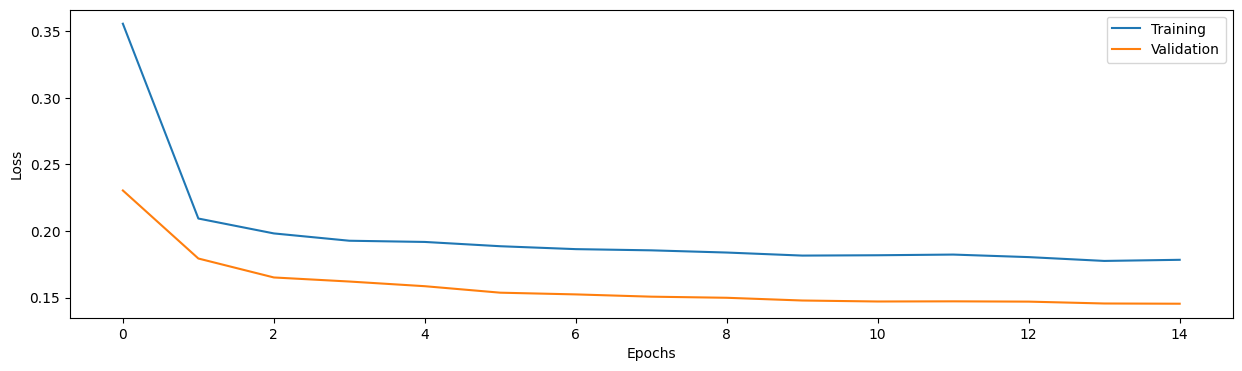

In [ ]:
# save model, scores and plot and check size of model is under 100MB
model_name = "22_05_25_sampling-weighting"

def get_model_size_mb(model):
    path = "temp_model.pth"
    torch.save(model.state_dict(), path)
    size_mb = os.path.getsize(path) / (1024 * 1024)
    os.remove(path)
    return size_mb

path_name_model = "/content/model_" + model_name+".pt"
path_name_plot = "/content/model_" + model_name + "_losscurve.png"
path_name_scores = "/content/model_" + model_name + "_scores.txt"

torch.save(model.state_dict(), path_name_model)
print(f"Model saved to {path_name_model}")
size_mb = os.path.getsize(path_name_model) / (1024 * 1024)
print(f"Model size: {size_mb} MB")

plt.figure(figsize=(15,4))
plt.plot(train_losses,label="Training")
plt.plot(test_losses,label="Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.savefig(path_name_plot)

import json
with open(path_name_scores, 'w') as file:
     file.write(json.dumps(metrics))

Model initialized.


  0%|          | 0/15 [00:00<?, ?it/s]


Train Epoch: 0 [0/29996 (0%)]	Loss: 0.712450

Train Epoch: 0 [25600/29996 (85%)]	Loss: 0.201422


  7%|▋         | 1/15 [01:22<19:11, 82.26s/it]


Train Epoch: 1 [0/29996 (0%)]	Loss: 0.196943

Train Epoch: 1 [25600/29996 (85%)]	Loss: 0.208401


 13%|█▎        | 2/15 [02:44<17:46, 82.06s/it]


Train Epoch: 2 [0/29996 (0%)]	Loss: 0.204597

Train Epoch: 2 [25600/29996 (85%)]	Loss: 0.187474


 20%|██        | 3/15 [04:06<16:25, 82.12s/it]


Train Epoch: 3 [0/29996 (0%)]	Loss: 0.183027

Train Epoch: 3 [25600/29996 (85%)]	Loss: 0.185780


 27%|██▋       | 4/15 [05:28<15:01, 81.94s/it]


Train Epoch: 4 [0/29996 (0%)]	Loss: 0.191189

Train Epoch: 4 [25600/29996 (85%)]	Loss: 0.182490


 33%|███▎      | 5/15 [06:49<13:38, 81.89s/it]


Train Epoch: 5 [0/29996 (0%)]	Loss: 0.178798

Train Epoch: 5 [25600/29996 (85%)]	Loss: 0.167923


 40%|████      | 6/15 [08:11<12:16, 81.86s/it]


Train Epoch: 6 [0/29996 (0%)]	Loss: 0.188909

Train Epoch: 6 [25600/29996 (85%)]	Loss: 0.179085


 47%|████▋     | 7/15 [09:33<10:54, 81.80s/it]


Train Epoch: 7 [0/29996 (0%)]	Loss: 0.172485

Train Epoch: 7 [25600/29996 (85%)]	Loss: 0.172718


 53%|█████▎    | 8/15 [10:55<09:32, 81.82s/it]


Train Epoch: 8 [0/29996 (0%)]	Loss: 0.186404

Train Epoch: 8 [25600/29996 (85%)]	Loss: 0.179902


 60%|██████    | 9/15 [12:16<08:10, 81.78s/it]


Train Epoch: 9 [0/29996 (0%)]	Loss: 0.184572

Train Epoch: 9 [25600/29996 (85%)]	Loss: 0.188338


 67%|██████▋   | 10/15 [13:38<06:48, 81.77s/it]


Train Epoch: 10 [0/29996 (0%)]	Loss: 0.183558

Train Epoch: 10 [25600/29996 (85%)]	Loss: 0.178932


 73%|███████▎  | 11/15 [15:00<05:27, 81.78s/it]


Train Epoch: 11 [0/29996 (0%)]	Loss: 0.186202

Train Epoch: 11 [25600/29996 (85%)]	Loss: 0.167957


 80%|████████  | 12/15 [16:22<04:05, 81.75s/it]


Train Epoch: 12 [0/29996 (0%)]	Loss: 0.174229

Train Epoch: 12 [25600/29996 (85%)]	Loss: 0.181039


 87%|████████▋ | 13/15 [17:44<02:43, 81.95s/it]


Train Epoch: 13 [0/29996 (0%)]	Loss: 0.166970

Train Epoch: 13 [25600/29996 (85%)]	Loss: 0.178928


 93%|█████████▎| 14/15 [19:06<01:22, 82.06s/it]


Train Epoch: 14 [0/29996 (0%)]	Loss: 0.181296

Train Epoch: 14 [25600/29996 (85%)]	Loss: 0.176649


100%|██████████| 10000/10000 [00:35<00:00, 281.25it/s]



Predictions computed for test set.


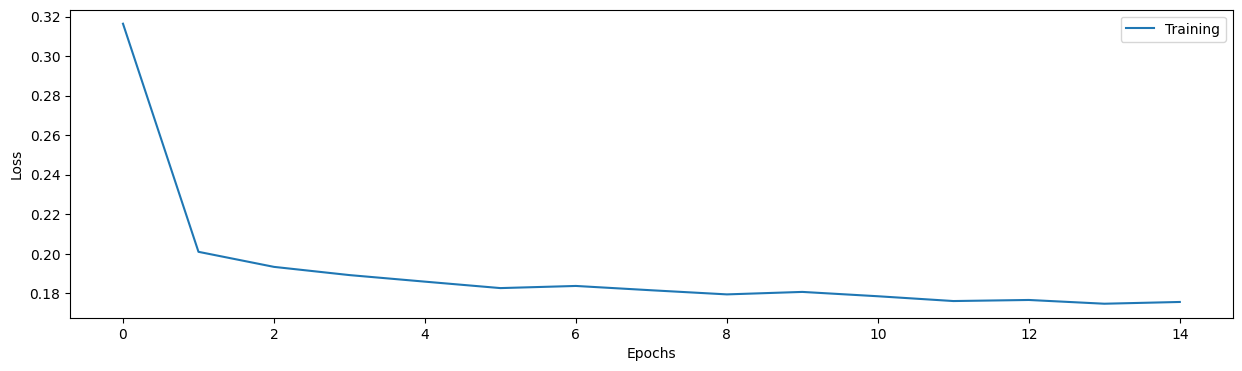

In [ ]:
# Training new model on the full dataset
model_full = CNN().to(device)
#weights = pos_weight(df_train,barplot=False).to(device)
loss = torch.nn.BCEWithLogitsLoss()
optimizer_full = torch.optim.Adam(model_full.parameters(), lr=lr)
print('Model initialized.')
train_losses_full = train_network(log_interval,model_full, device, train_dataloader, test_loader=0,optimizer=optimizer_full, loss=loss,epochs=15)

plt.figure(figsize=(15,4))
plt.plot(train_losses_full,label="Training")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')

# Compute predictions for true test set
thresholds_full = thresholds
thresholds_full[11] = 1.1
print(thresholds_full)
test_pred = test(model_full, device, test_dataloader,loss,threshold=thresholds_full=full,target_available=False)

In [ ]:
# Convert predictions to csv
from tqdm import tqdm
import numpy as np

def get_class(array):
  return np.where(array > 0.5)[1] +1

def unencode(y_pred):
  labels = []
  for i in tqdm(range(len(y_pred))):
    temp = y_pred[i].cpu()
    temp = np.asarray(temp)
    temp = get_class(temp)
    temp = " ".join(str(item) for item in temp)
    labels.append(temp)
  return labels

#cpu_preds = torch.tensor(val_pred, device =  'cpu')
pred_labels= unencode(test_pred)
pred_df = df_test.copy()
pred_df = pred_df.drop("Caption",axis=1)
pred_df["Labels"] = pred_labels
print("Submission dataframe:")
print(pred_df.describe)
submission_name = "/content/submission_newest.csv"
pred_df.to_csv(submission_name,index=False)
print(f"Predictions saved as {submission_name}")

100%|██████████| 10000/10000 [00:00<00:00, 23759.32it/s]

Submission dataframe:
<bound method NDFrame.describe of         ImageID Labels
0     30000.jpg       
1     30001.jpg      1
2     30002.jpg      1
3     30003.jpg      1
4     30004.jpg      1
...         ...    ...
9995  39995.jpg      1
9996  39996.jpg      1
9997  39997.jpg      1
9998  39998.jpg      1
9999  39999.jpg      1

[10000 rows x 2 columns]>
Predictions saved as /content/submission_newest.csv


In [ ]:
# Submit predictions
! kaggle competitions submit -c multi-label-classification-competition-2025 -f /content/submission.csv -m "playing with thresholds"

[Errno 2] No such file or directory: '/content/submission.csv'
